# Modeling

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

# XGBoost
from xgboost import XGBRegressor, XGBClassifier
import xgboost

# Dask
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask_ml.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from dask_ml.preprocessing import DummyEncoder, RobustScaler

# Other utilities
import joblib

In [2]:
client = Client(n_workers=16)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:35215 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 84.47 GB


I will begin by first hiding all history information from a linear regression model, predicting prices then calculating the errors. In this case I am hoping that errors are not heteroditastic but instead are related to the information hidden from the model.

Then I will add those errors as a feature for a classification model.

In [4]:
# Add a section here wher I compare results of a price prediction model with and without the target
# The version with the target should perform better if I want 
#to make the case that variable contains information that would be 'missing' otherwise

In [5]:
# Load the cleaned dataset
df = dd.read_parquet('cars_cleaned.parquet')

In [6]:
# Encode the categorical variables
de = DummyEncoder()
df = df.categorize()

# It may be worth setting vin as index to retain it
w_dummies = de.fit_transform(df)

In [7]:
# Use one third of the data to fit a model to predict prices
price_predict, report_predict= train_test_split(w_dummies, test_size=.66, shuffle=False)

In [8]:
# Predict the prices and record errors
# In order to see how the errors might represent the missing information from history

X_price = price_predict.drop(['price', 'target'], axis=1)

y_price = price_predict['price']

In [9]:
# Train a variety of models on this subset
# Then use the trained models to predict price for the other subset and record the errors

In [15]:
# OLS price prediction errors

lrm = LinearRegression()
with joblib.parallel_backend('dask'):    
    lrm.fit(X_price, y_price)

    lrm_preds = lrm.predict(report_predict.drop(['target', 'price'], axis=1))

lrm_errors = lrm_preds - report_predict['price'].compute()

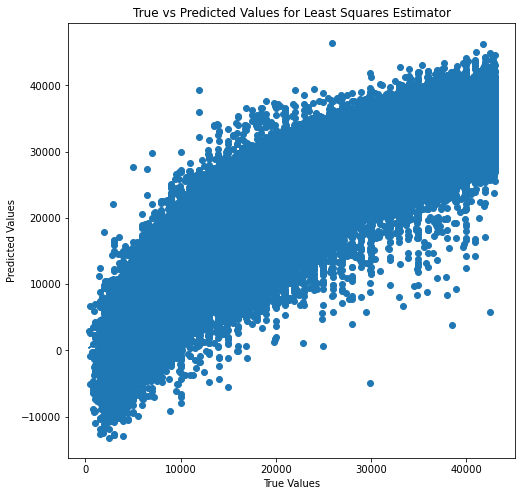

In [16]:
true_prices = report_predict['price'].compute()


plt.figure(figsize=(8,8))
plt.plot(true_prices, true_prices)
plt.scatter(true_prices, lrm_preds)
plt.title('True vs Predicted Values for Least Squares Estimator')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [17]:
# Ada Boost price prediction errors

adr = AdaBoostRegressor(n_estimators=100)

with joblib.parallel_backend('dask'):
    adr.fit(X_price, y_price)
    
    adr_preds = adr.predict(report_predict.drop(['target', 'price'], axis=1))
    
adr_errors = adr_preds - report_predict['price'].compute()

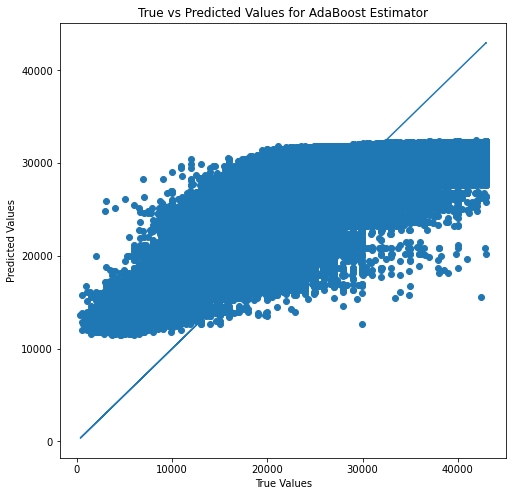

In [18]:
plt.figure(figsize=(8,8))
plt.plot(true_prices, true_prices)
plt.scatter(true_prices, adr_preds)
plt.title('True vs Predicted Values for AdaBoost Estimator')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [22]:
# Random Forest Price prediction errors
rfr = RandomForestRegressor(n_estimators=200, max_depth=5)

with joblib.parallel_backend('dask'):
    rfr.fit(X_price, y_price)
    
    rfr_preds = rfr.predict(report_predict.drop(['target', 'price'], axis=1))
    
rfr_errors = rfr_preds - report_predict['price'].compute()

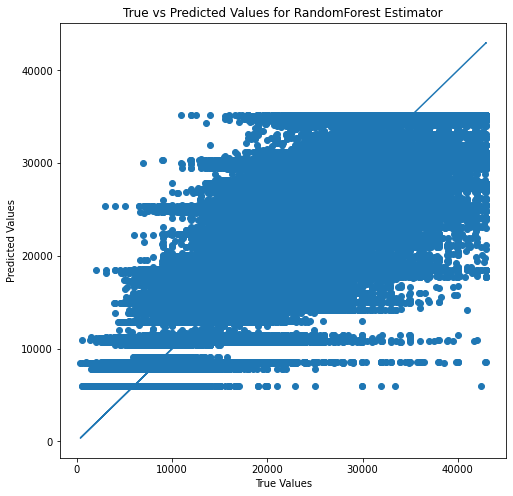

In [23]:
plt.figure(figsize=(8,8))
plt.plot(true_prices, true_prices)
plt.scatter(true_prices, rfr_preds)
plt.title('True vs Predicted Values for RandomForest Estimator')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [24]:
# XGB price prediction errors

params = {'learning_rate' : 1,
          'max_depth' : 5
          ,'booster' : 'gbtree'
          , 'gamma' : 0
          , 'client' : client
          , 'n_jobs' : -1
          , 'objective' : 'reg:squarrederror'
         }

xgb = XGBRegressor(params=params)

xgb.fit(X_price, y_price)

xgb_preds = xgb.predict(report_predict.drop(['target', 'price'], axis=1))

xgb_errors = xgb_preds - report_predict['price'].compute()

[17:13:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


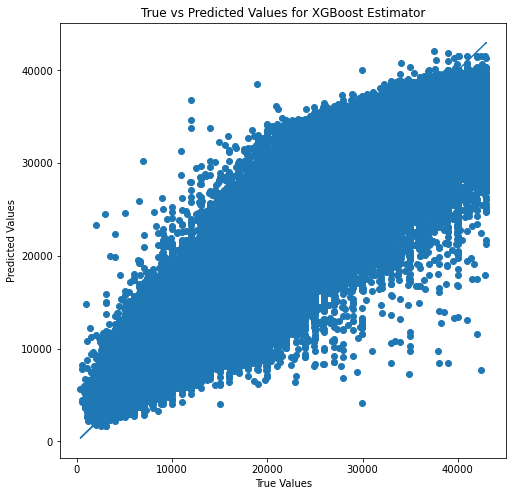

In [25]:
plt.figure(figsize=(8,8))
plt.plot(true_prices, true_prices)
plt.scatter(true_prices, xgb_preds)
plt.title('True vs Predicted Values for XGBoost Estimator')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [26]:
# Okay but now do these errors have any predictive power?
# Attempt to classify

In [28]:
# Store the results of various price predictions

error_results = pd.DataFrame(
    {'xgboost_errors' : xgb_errors
     , 'adaboost_errors': adr_errors
     , 'lrm_errors' : lrm_errors
     , 'random_forest_errors' : rfr_errors
    })

In [ ]:
# Classifying using errors as a feature

In [30]:
# Write the errors out to file
error_results.to_csv('errors.csv')

In [31]:
# Fit and score a model using each set of errors.

params = {'learning_rate' : 1,
          'max_depth' : 6
          ,'booster' : 'gbtree'
          , 'gamma' : 0
          , 'client' : client
          , 'n_jobs' : -1
          , 'objective' : 'binary:logistic'
          , 'scale_pos_weight': 6
         }
xgbc = XGBClassifier(params=params)

for column in error_results:
    
    data = report_predict.join(pd.DataFrame(error_results[column]))
    
    X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1)
                                                    , data['target'], test_size=.25, shuffle=False)
    
    xgbc.fit(X_train, y_train)
    
    score = xgbc.score(X_test, y_test)
    
    print(f'Score for {column}:')
    print(score)

Score for xgboost_errors:
0.8345148476971722
Score for adaboost_errors:
0.8326746238026239
Score for lrm_errors:
0.8329649563852942
Score for random_forest_errors:
0.8329865835966757


In [32]:
# Performance is no better than a dummy classifier. 
# Check feature importances.

pd.DataFrame({'feature' : data.drop('target', axis=1).columns,  'importance' : xgbc.feature_importances_}
            ).sort_values(by='importance', ascending=False).head(20)

,feature,importance
7,price,0.174533
8,age,0.168513
2,franchise_dealer,0.116310
6,mileage,0.108883
4,is_cpo,0.048133
115,random_forest_errors,0.030349
62,make_name_Ford,0.029926
57,make_name_Honda,0.026640
89,make_name_Subaru,0.020793
1,daysonmarket,0.019087


In [33]:
# What about limiting the features?

cols = ['price', 'age', 'franchise_dealer', 'mileage', 'is_cpo', 'target']

kept = report_predict.loc[:, cols]

In [34]:
# Fit and score a model using each set of errors.

params = {'learning_rate' : 1,
          'max_depth' : 6
          ,'booster' : 'gbtree'
          , 'gamma' : 0
          , 'client' : client
          , 'n_jobs' : -1
          , 'objective' : 'binary:logistic'
          , 'scale_pos_weight': 6
         }
xgbc = XGBClassifier(params=params)

for column in error_results:
    
    data = kept.join(pd.DataFrame(error_results[column]))
    
    X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1)
                                                    , data['target'], test_size=.25, shuffle=False)
    
    xgbc.fit(X_train, y_train)
    
    score = xgbc.score(X_test, y_test)
    
    print(f'Score for {column}:')
    print(score)

Score for xgboost_errors:
0.8327734313349717
Score for adaboost_errors:
0.8318022194128388
Score for lrm_errors:
0.8331359344861426
Score for random_forest_errors:
0.8335921047431388


In [35]:
# Try a random forest classifier

rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)
with joblib.parallel_backend('dask'):
    for column in error_results:

        data = report_predict.join(pd.DataFrame(error_results[column]))

        X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1)
                                                        , data['target'], test_size=.25, shuffle=False)

        rfc.fit(X_train, y_train)

        score = rfc.score(X_test, y_test)

        print(f'Score for {column}:')
        print(score)

Score for xgboost_errors:
0.8274240598285785
Score for adaboost_errors:
0.8270385783376448
Score for lrm_errors:
0.8285814674396595
Score for random_forest_errors:
0.8262977528089888


Unfortunately it seems at this time that the information needed to solve the classification problem is not present within the data. Upon further consideration this may be due to bias in the data. These cars are all for sale mostly by dealers. It seems likely that a significant of the cars with a negative history have been excluded already. The population of cars that we really want are those at auction or otherwise less currated. 

However it may be possible to collect the data that I need by creating a product of value for auto-traders. As discussed in the proposal many of the firms that provide auto history reports implement an API and by re-selling these reports to the end-user at cost I could retain a copy of that data in order to better train the model. This would change the population sampled to be vehicles that traders think have a good chance of selling and are concerned might have a negative history (though some users are likely to purchase a report for every vehicle they consider). I had originally hoped to use this as a way of updating and improving the model over time.

With this in mind I will move ahead with tuning the price prediction component of this product further as it will now be the main solution offered to end-users.

Given that the classification solution was a failure I will use the entiere dataset for this task now. I will however continue to hide the history information from this model because it would be unknown in the final application. 

In [41]:
y = w_dummies['price']
X = w_dummies.drop(['price', 'target'], axis=1)

distributed.nanny - WARNING - Restarting worker


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312, shuffle=False)

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [43]:
# Persist the training and test sets
X_train.persist()
X_test.persist()
y_train.persist()
y_test.persist()

Dask Series Structure:
npartitions=1
19UDE2F30GA022490    float64
ZN661YUA1HX196850        ...
Name: price, dtype: float64
Dask Name: split, 1 tasks

In [46]:
rfr = RandomForestRegressor(max_depth=4, n_estimators=100, n_jobs=-1)

with joblib.parallel_backend('dask'):
    scores = cross_validate(rfr, X_train.compute(), y_train.compute(), cv=4)
    
scores

{'fit_time': array([93.67333817, 85.33623505, 91.80198336, 78.07745695]),
 'score_time': array([0.18777537, 0.2859652 , 0.28247356, 0.48712659]),
 'test_score': array([0.70072286, 0.5066879 , 0.68769508, 0.63485612])}

In [45]:
adr = AdaBoostRegressor(n_estimators=100)

with joblib.parallel_backend('dask'):
    scores = cross_validate(adr, X_train.compute(), y_train.compute())

scores

{'fit_time': array([675.76973009, 519.22631192, 686.09150243, 665.21044993,
        634.51133585]),
 'score_time': array([5.8532517 , 4.49436879, 5.81223154, 6.06161714, 6.178931  ]),
 'test_score': array([0.64301423, 0.55512254, 0.33701866, 0.55888509, 0.56782433])}

In [49]:
lrm = LinearRegression()
    
with joblib.parallel_backend('dask'):
    scores = cross_validate(lrm, X_train.compute(), y_train.compute(), cv=4)
scores

{'fit_time': array([9.03922272, 9.26475215, 5.67798305, 5.76352   ]),
 'score_time': array([0.15008426, 0.14502239, 0.15184665, 0.15567493]),
 'test_score': array([0.81235897, 0.76692591, 0.84318215, 0.78130737])}

In [69]:
params = {'learning_rate' : 1,
          'max_depth' : 5
          ,'booster' : 'gbtree'
          , 'gamma' : 0
          , 'client' : client
          , 'n_jobs' : -1
          , 'objective' : 'reg:squarrederror'
         }
xgb = XGBRegressor(params=params)


# XGBoost API does not support cross_validate out of the box so use a loop and subsample the dataset
for i in range(4):

    # Use have the data for each fit and score
    sub_sample = w_dummies.sample(frac=.5)
    
    y = sub_sample['price']
    X = sub_sample.drop(['price', 'target'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312, shuffle=False)

    xgb.fit(X_train.compute(), y_train.compute())
    
    score = xgb.score(X_test.compute(), y_test.compute())
    
    print(f'Round {i}:')
    print(f'Test Score: {score}')

[21:01:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Round 0:
Test Score: 0.8809281055988649
[21:03:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Round 1:
Test Score: 0.8809816000195405
[21:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Round 2:
Test Score: 0.8799501769226299
[21:09:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Round 3:
Test Score: 0.8803188486866562


In [7]:
# Split into training and testing using the whole dataset again

y = w_dummies['price']
X = w_dummies.drop(['price', 'target'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312, shuffle=False)

In [8]:
# XGBoost is the most performant model
# Now I will tune it with a RandomizedSearchCV

params = {'objective' : ['reg:squarederror']
          , 'booster' : ['gbtree', 'gblinear']
          , 'max_depth' : [2,3,4,5,6,7,8]
          , 'gamma' : np.arange(0, 1, .1)
          , 'learning_rate' : np.arange(.1, 1, .1)
         }

xgb = XGBRegressor()

search = RandomizedSearchCV(xgb, params, scheduler=client, n_iter=200)

search.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=200,
                   param_distributions={'booster': [

In [9]:
# what are the paramaters identified in the search?
search.best_params_

{'objective': 'reg:squarederror',
 'max_depth': 7,
 'learning_rate': 0.30000000000000004,
 'gamma': 0.1,
 'booster': 'gbtree'}

In [10]:
client

Client Scheduler: tcp://127.0.0.1:35215 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 84.47 GB


In [14]:
# Initialize a model using those paramaters

params = {'objective': 'reg:squarederror'
          , 'max_depth': 7
          , 'learning_rate': 0.3
          , 'gamma': 0.1
          , 'booster': 'gbtree'
          , 'client' : client
          
         }

xgb = XGBRegressor(params=params)

In [15]:
# train the model
xgb.fit(X_train, y_train)

[21:11:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             params={'booster': 'gbtree',
                     'client': <Client: 'tcp://127.0.0.1:35215' processes=16 threads=16, memory=84.47 GB>,
                     'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 7,
                     'objective': 'reg:squarederror'},
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [16]:
# Check the scores on the training set
xgb.score(X_train, y_train)

0.9397049010592002

In [17]:
# And on the test set
xgb.score(X_test, y_test)

0.9380845521716772

In [18]:
# This model has fairly good accuracy and does not seem to be overfitting
# Now I will evaluate using other metrics

In [21]:
y_preds = xgb.predict(X_test)

print('R-squared for the training set is: {}'.format(xgb.score(X_train, y_train)))
print('R-squared for the test set is: {}'.format(xgb.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test.compute(), y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test.compute(), y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test.compute(), y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test.compute() - y_preds) / y_test.compute())) * 100))

R-squared for the training set is: 0.9397049010592002
R-squared for the test set is: 0.9380845521716772
Mean absolute error of the prediction is: 1646.5228460361793
Mean squared error of the prediction is: 4889722.741974678
Root mean squared error of the prediction is: 2211.2717476544303
Mean absolute percentage error of the prediction is: 9.149716393381013


In [24]:
# Examine the feature importances


pd.DataFrame({'feature' : X_train.columns,  'importance' : xgb.feature_importances_}
            ).sort_values(by='importance', ascending=False).head(20)

,feature,importance
109,wheel_system_FWD,0.120204
3,horsepower,0.083435
7,age,0.075622
61,make_name_Ford,0.043738
58,make_name_Dodge,0.038435
18,engine_type_V6,0.033940
30,engine_type_I4 Diesel,0.032788
79,make_name_Lexus,0.032643
23,engine_type_V6 Flex Fuel Vehicle,0.030427
87,make_name_Mercedes-Benz,0.029761


These feature importances are somewhat surprising. Given the mileage and age were moderately correlated with price it is odd that their importances are so low. It could be due to the prevelence of categorical features. Given the performance of the model this is not too concerning but I will try another iteration with fewer features and see the outcome.

In [31]:
kept = ['body_type', 'horsepower', 'make_name',
        'mileage', 'price', 'age']

In [32]:
subset = de.fit_transform(df.loc[:, kept].categorize())

X = subset.drop('price', axis=1)
y = subset['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1312)

# Use the same paramaters 
xgb = XGBRegressor(params=params)

xgb.fit(X_train, y_train)


train_score = xgb.score(X_train, y_train)

test_score = xgb.score(X_test, y_test)

print(f'Train R-squared: {train_score}')
print(f'Test R-squared: {test_score}')
    

/home/owen/anaconda3/envs/MLOPS/lib/python3.8/site-packages/dask_ml/model_selection/_split.py:462: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


[22:19:56] WARNING: /workspace/src/learner.cc:480: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train R-squared: 0.9228093414983769
Test R-squared: 0.9210368560589687


In [34]:
# Examine the feature importances


pd.DataFrame({'feature' : X_train.columns,  'importance' : xgb.feature_importances_}
            ).sort_values(by='importance', ascending=False).head(20)

,feature,importance
15,make_name_Dodge,0.090959
2,age,0.079925
0,horsepower,0.073494
18,make_name_Ford,0.069381
36,make_name_Lexus,0.049206
41,make_name_BMW,0.048448
44,make_name_Mercedes-Benz,0.037499
45,make_name_Subaru,0.035655
55,make_name_Audi,0.035323
30,make_name_Toyota,0.035136


Most of the predictive power is retained even with the smaller subset of features, which indicates that the feature importances as reported by the algorithm might not have that much bearing on their actual predictive power. Again however the overall performance of the model indicates that there are no significant problems with using all of the available features. 

## Conclusions and Discussion

While the original intent of this project was unsucessful I was still able to produce a viable product. Price prediction of used cars will allow auto-traders to make better decisions about which vehicles to invest in.

Based upon  R-squared XGBoost strongly outperformed the other model options. XGboost also benefits from being one of the most scalable algorithms and natively supports big data frameworks better than the others. For this reason I have selected it as the model to use in my product.


### Next Steps for deployment
Two potentially important features (exterior color and description) were excluded from this model because they require natural language processing / unstructured data. While this is beyond the scope of this project, and I was ultimately able to achieve satisfactory performance without them that would be the logical next step for refinement of the model.

While the original concept of this model failed, it could have been due to a biased sample of data. By collecting data about the cars that dealers are actually interested in it may be possible to get data that would make the original purpose of this project possible - to identify cars with a negative history without having to purchase a report. This can be implemented internally and if performance improves suffficently could eventually be rolled out to the end user.